In [1]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Fit a mesh via rendering

This tutorial shows how to:
- Load a mesh and textures from an `.obj` file. 
- Create a synthetic dataset by rendering a textured mesh from multiple viewpoints
- Fit a mesh to the observed synthetic images using differential silhouette rendering
- Fit a mesh and its textures using differential textured rendering

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [2]:
# import os
# import sys
# import torch
# need_pytorch3d=False
# try:
    # import pytorch3d
# except ModuleNotFoundError:
    # need_pytorch3d=True
# if need_pytorch3d:
    # We try to install PyTorch3D from source.
    # !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
    # !tar xzf 1.10.0.tar.gz
    # os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
    # !pip install 'git+https://github.com/theycallmepeter/pytorch3d_PBR/pytorch3d.git@normal_maps'

In [3]:
import os
import torch
from torch import nn
from torchvision.transforms import RandomAffine, Resize
import optuna


import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torchvision.transforms import RandomAffine, Resize

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    NormalMeshRenderer,
    MeshRasterizer,  
    NormalSoftPhongShader,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    TexturesUV,
    tbn_matrices,
)

from pytorch3d.renderer.mesh import tbn_matrices
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

If using **Google Colab**, fetch the utils file for plotting image grids:

In [4]:
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
# from plot_image_grid import image_grid

OR if running **locally** uncomment and run the following cell:

In [5]:
 from utils.plot_image_grid import image_grid

### 1. Load a mesh and texture file

Load an `.obj` file and its associated `.mtl` file and create a **Textures** and **Meshes** object. 

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes. 

**TexturesVertex** is an auxiliary datastructure for storing vertex rgb texture information about meshes. 

**Meshes** has several class methods which are used throughout the rendering pipeline.

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cow_mesh`:
If running locally, the data is already available at the correct path. 

In [6]:
# !mkdir -p data/cow_mesh
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

In [7]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")
# obj_filename = os.path.join(DATA_DIR, "cube_mesh/six_colour_cube.obj")


# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((0.75 / float(scale)));

## 2. Dataset Creation

We sample different camera positions that encode multiple viewpoints of the cow.  We create a renderer with a shader that performs texture map interpolation.  We render a synthetic dataset of images of the textured cow mesh from multiple viewpoints.


/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


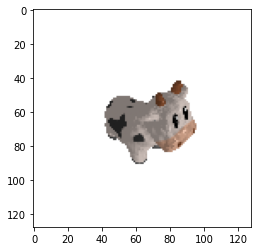

In [8]:
imsize = 128
# lights = PointLights(device=device, location=[[0.0, 0.0, -1.5]])
lights = DirectionalLights(direction=[[0.0, 0.0, -1.0]], device=device)

# We arbitrarily choose one particular view that will be used to visualize 
# results
# Changed to novel view
rand_elev = 45
rand_azim = 135
R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)

camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
                                  T=T_novel) 


# camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
#                                   T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=imsize, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    perspective_correct=False,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
TBN_matrices = tbn_matrices(mesh)
renderer = NormalMeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=NormalSoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=TBN_matrices,
    )
)
random_target, _ = renderer(mesh, cameras=camera, lights=lights)
random_target = random_target[...,:3]
plt.imshow(random_target.cpu().numpy()[0])

In [9]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 30
batch_views = 1
imsize = 128
# Get a batch of viewing angles. 
elev = np.random.permutation(torch.linspace(0, 360, num_views))
azim = np.random.permutation(torch.linspace(-180, 180, num_views))
# elev = np.array([45, 45, 225, 225])
# azim = np.array([-45, 135, -45, 135])

def train_test_split(list):
    return list[:len(list)//2], list[len(list)//2:]

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
# cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
# Changed to novel view
rand_elev = torch.rand((1,))*360
rand_azim = torch.rand((1,))*360 - 180
R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)

camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
                                  T=T_novel) 


# camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
#                                   T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 

normals_hook = torch.Tensor()
raster_settings = RasterizationSettings(
    image_size=imsize, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    perspective_correct=False,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = NormalMeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=NormalSoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=TBN_matrices,
    )
)

# for i
# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_views)
target_rgb = []
target_cameras = []
target_normals = []
print()
# Render small batches of target views on GPU and append to list to be later converted to CPU tensor
for i in range(num_views // batch_views):
    # Create cameras for rendering the batch
    cameras = OpenGLPerspectiveCameras(device=device, R=R[i*batch_views:(i+1)*batch_views], T=T[i*batch_views:(i+1)*batch_views])
    # Render the cow mesh from each viewing angle
    target_images_batch, normals = renderer(meshes, cameras=cameras, lights=lights)

    # Our multi-view cow dataset will be represented by these 2 lists of tensors,
    # each of length num_views.
    target_rgb_batch = [target_images_batch[i, ..., :3].cpu() for i in range(batch_views)]
    target_cameras_batch = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(i*batch_views,(i+1)*batch_views)]
    target_rgb.extend(target_rgb_batch)
    target_cameras.extend(target_cameras_batch)
    target_normals.append(normals)


# 50/50 split of views for train/test
target_rgb, test_rgb = train_test_split(target_rgb)
target_cameras, test_cameras = train_test_split(target_cameras)
target_normals, test_normals = train_test_split(target_normals)

random_target, _ = renderer(mesh, cameras=camera, lights=lights)
random_target = random_target[...,:3]
print(len(target_rgb), len(target_cameras))


15 15


Visualize the dataset:

/tmp/ipykernel_18902/1255958388.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  image_grid(np.asarray(target_rgb[:10]), rows=2, cols=5, rgb=True)
/tmp/ipykernel_18902/1255958388.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_grid(np.asarray(target_rgb[:10]), rows=2, cols=5, rgb=True)


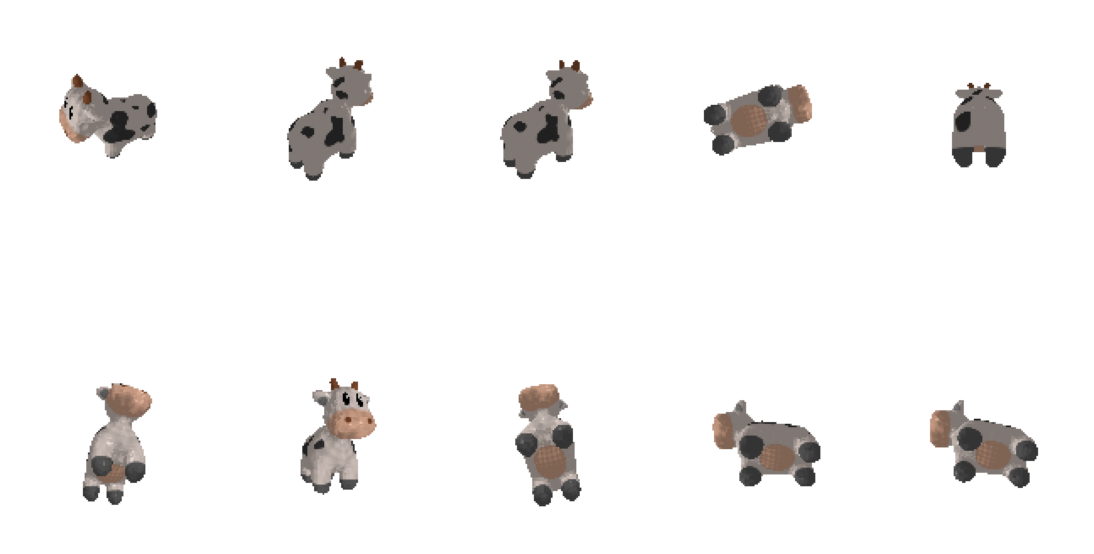

In [10]:
# RGB images
print()

image_grid(np.asarray(target_rgb[:10]), rows=2, cols=5, rgb=True)
plt.show()

Later in this tutorial, we will fit a mesh to the rendered RGB images, as well as to just images of just the cow silhouette.  For the latter case, we will render a dataset of silhouette images.  Most shaders in PyTorch3D will output an alpha channel along with the RGB image as a 4th channel in an RGBA image.  The alpha channel encodes the probability that each pixel belongs to the foreground of the object.  We construct a soft silhouette shader to render this alpha channel.

/tmp/ipykernel_18902/579964652.py:37: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  print(np.asarray(target_silhouette[:10])[0].shape)
/tmp/ipykernel_18902/579964652.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.asarray(target_silhouette[:10])[0].shape)
/tmp/ipykernel_18902/579964652.py:38: FutureWarning: The input object of type 'Tensor' is an array

torch.Size([128, 128])


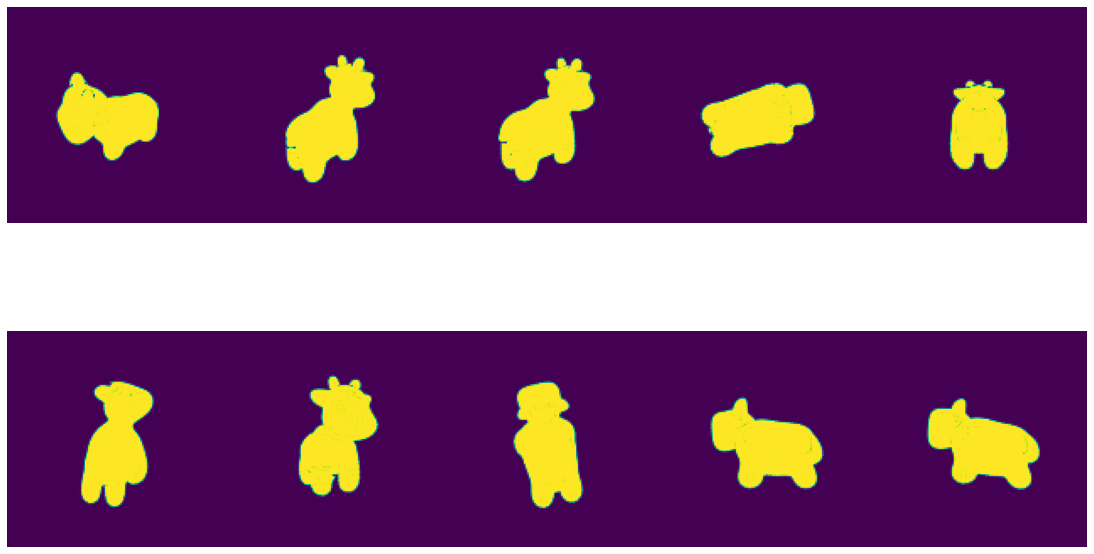

In [11]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
target_silhouette = []
silhouette_images = []
for i in range(num_views // batch_views):
    # Create cameras for rendering the batch
    cameras = OpenGLPerspectiveCameras(device=device, R=R[i*batch_views:(i+1)*batch_views], T=T[i*batch_views:(i+1)*batch_views])
    # Render the cow mesh from each viewing angle
    silhouette_images_batch = renderer_silhouette(meshes, cameras=cameras, lights=lights)
    silhouette_images.extend(silhouette_images_batch.cpu())
    # Our multi-view cow dataset will be represented by these 2 lists of tensors,
    # each of length num_views.
    target_silhouette_batch = [silhouette_images_batch[i, ..., 3].cpu() for i in range(batch_views)]
    # target_cameras_batch = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                        #    T=T[None, i, ...]) for i in range(i*batch_views,(i+1)*batch_views)]
    target_silhouette.extend(target_silhouette_batch)
    # target_cameras.extend(target_cameras_batch)
# Visualize silhouette images
print(np.asarray(target_silhouette[:10])[0].shape)
image_grid(np.asarray(silhouette_images[:10]), rows=2, cols=5, rgb=False)
plt.show()

## 3. Mesh prediction via silhouette rendering
In the previous section, we created a dataset of images of multiple viewpoints of a cow.  In this section, we predict a mesh by observing those target images without any knowledge of the ground truth cow mesh.  We assume we know the position of the cameras and lighting.

We first define some helper functions to visualize the results of our mesh prediction:

In [12]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette, 
                         target_image=random_target[0], title='', 
                         silhouette=False, camera = camera):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images, _ = renderer(predicted_mesh, cameras=camera)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

Starting from a sphere mesh, we will learn offsets of each vertex such that the predicted mesh silhouette is more similar to the target silhouette image at each optimization step.  We begin by loading our initial sphere mesh:

In [13]:
# We initialize the source shape to be a sphere of radius 1.  
silhouette_src_mesh = ico_sphere(4, device)
# src_mesh = mesh.clone()

torch.Size([2562]) torch.Size([2562])
torch.Size([2562, 2]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Target shapes faces: torch.Size([1, 5856, 3]), verts: torch.Size([1, 2930, 3])
Target shapes facesUVs: torch.Size([1, 5856, 3]), vertsUVs: torch.Size([1, 3225, 2])
torch.Size([2562, 3])


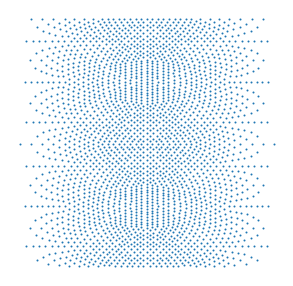

In [18]:
# Functions from my L4 project
def to_geocentric(lat, lon):
    """
    Converts a latitude longitude pair to geocentric X Y Z coordinates
    """
    lat = np.radians(lat)
    lon = np.radians(lon)
    return np.array([np.cos(lat) * np.cos(lon), np.cos(lat) * np.sin(lon), np.sin(lat)])

# lat lon but longitude is scaled to half to have a square representation
def to_lat_lon(coords):
    """
    Converts X Y Z geocentric coordinates into latitude and longitude
    """
    return np.array([np.degrees(np.arcsin(coords[2])), np.degrees(np.arctan2(coords[1], coords[0]))])

# Creating UVs for sphere using equirectangular projection with scaled v axis
sphere_verts = silhouette_src_mesh.verts_packed()
xyz_to_u = torch.rad2deg(torch.arcsin(sphere_verts[:,2])) + 90
xyz_to_v = (torch.rad2deg(torch.atan2(sphere_verts[:,1], sphere_verts[:,0])) + 180) / 2 
print(xyz_to_u.shape, xyz_to_v.shape)
sphere_verts_uvs = torch.stack([xyz_to_u, xyz_to_v], dim=1) / 180
print(sphere_verts_uvs.shape, sphere_verts_uvs.max(), sphere_verts_uvs.min())
# need to solve seams somehow
# u = 0.5 + (torch.atan2(verts[:,0], verts[:,1])/(np.pi*2))
# v = 0.5 - (torch.arcsin(verts[:,2])/np.pi)
# uv_map = torch.stack([u,v], dim=1).unsqueeze(dim=0).to(device)
print("Target shapes faces: {}, verts: {}".format(mesh.faces_padded().shape, mesh.verts_padded().shape, ))
print("Target shapes facesUVs: {}, vertsUVs: {}".format(mesh.textures.faces_uvs_padded().shape,  mesh.textures.verts_uvs_padded().shape))
print(silhouette_src_mesh.verts_packed().shape)
# silhouette_src_mesh.verts_padded().map
plt.figure(figsize=(5,5))
plt.scatter(sphere_verts_uvs.cpu()[:,0], sphere_verts_uvs.cpu()[:,1], s=1)
plt.axis("off")
plt.savefig("texture_uvs_illustration.pdf", bbox_inches="tight")
silhouette_src_mesh.textures = TexturesUV(mesh.textures.maps_padded(), faces_uvs=silhouette_src_mesh.faces_packed().unsqueeze(0), verts_uvs=sphere_verts_uvs.unsqueeze(0))

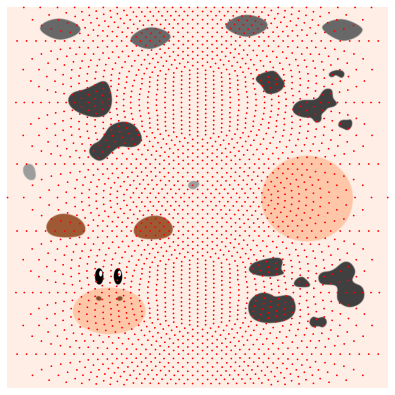

In [16]:
plt.figure(figsize=(7,7))
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=src_mesh.textures.maps_padded()
texturesuv_image_matplotlib(silhouette_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
plt.axis("off");

We create a new differentiable renderer for rendering the silhouette of our predicted mesh:

In [19]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target silhouettes:

In [20]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 5
# Number of optimization steps
Niter = 1000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal 
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)
    
    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)
    
    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = silhouette_src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

We write an optimization loop to iteratively refine our predicted mesh from the sphere mesh into a mesh that matches the silhouettes of the target images:

In [21]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = silhouette_src_mesh.offset_verts(deform_verts)
    
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)
    
    # Compute the average silhouette loss over two random views, as the average 
    # squared L2 distance between the predicted silhouette and the target 
    # silhouette from our dataset
    for j in np.random.permutation(len(target_cameras)).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j].to(device)) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration
    
    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))

    
    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)
    
    # Plot mesh
    # if i % plot_period == 0:
    #     visualize_prediction(new_src_mesh, title="iter: %d" % i, silhouette=True,
    #                          target_image=target_silhouette[1])
        
    # Optimization step
    sum_loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
silhouette_result = new_src_mesh.clone().detach()


## 3. Mesh and texture prediction via textured rendering
We can predict both the mesh and its texture if we add an additional loss based on the comparing a predicted rendered RGB image to the target image. As before, we start with a sphere mesh.  We learn both translational offsets and RGB texture colors for each vertex in the sphere mesh.  Since our loss is based on rendered RGB pixel values instead of just the silhouette, we use a **SoftPhongShader** instead of a **SoftSilhouetteShader**.

In [23]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019

new_TBN_matrices = tbn_matrices(silhouette_result)

sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=NormalSoftPhongShader(device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=new_TBN_matrices)
)


We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target RGB images:

We write an optimization loop to iteratively refine our predicted mesh and its vertex colors from the sphere mesh into a mesh that matches the target images:

In [24]:

# Texture generator Code
class Generator(nn.Module):
    def __init__(self, ngpu, ngf = 32, nc=3, nz=100, type = "normal", conv_layers = 4):
        super(Generator, self).__init__()
        self.type = type
        self.ngpu = ngpu
        self.deconv = nn.Sequential(
            # Testing convoluting target image first 
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ngf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Flatten(),
            nn.Linear(ngf * 4 * 16*16, nz),
            UnsqueezeLatent(),
        )
        self.tanh = nn.Tanh()           
        scale_factor = max(8, 8*(2**(4-conv_layers)))
        self.upsampler = nn.Upsample(scale_factor=scale_factor, mode='bilinear')

        if conv_layers < 5:
            self.normal_generator = nn.Sequential(
                nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 4, 2, 1, bias=False),
                nn.ReLU(True),
                nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
            )
            self.texture_generator = nn.Sequential(
                nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 4, 2, 1, bias=False),
                nn.ReLU(True),
                nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
            )
        else:
            self.normal_generator = nn.Sequential(
                nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 3, 1, 1, bias=False),
                # nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 4, 2, 1, bias=False),
                nn.ReLU(True),
                nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
            )
            self.texture_generator = nn.Sequential(
                # nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 4, 2, 1, bias=False),
                nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 3, 1, 1, bias=False),
                nn.ReLU(True),
                nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
            )
        modules = [nn.ConvTranspose2d(nz, int(ngf * (2**(conv_layers-2))), 4, 1, 0, bias=False),
            nn.BatchNorm2d(int(ngf * (2**(conv_layers-2)))),
            nn.ReLU(True)]

        # deconv layers that upscale by 2, maximum to 128x128
        for i in range(conv_layers - 2, max(conv_layers - 7, -2), -1):
            modules.extend([
            nn.ConvTranspose2d(int(ngf * (2**(i))), int(ngf * (2**(i-1))), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(ngf * (2**(i-1)))),
            nn.ReLU(True)
            ])
        # convolution layers without upscaling beyond 128x128 to save on memory
        if conv_layers >= 5:
            for j in range(conv_layers - 7, -2, -1):
                modules.extend([
                    nn.ConvTranspose2d(int(ngf * (2**(j))), int(ngf * (2**(j-1))), 3, 1, 1, bias=False),
                    nn.BatchNorm2d(int(ngf * (2**(j-1)))),
                    nn.ReLU(True) 
                ])

        self.generator = nn.Sequential(*modules)
    def forward(self, input):
        if self.type == "simultaneous":
            result = self.generator(input)
            return self.upsampler(self.tanh(self.texture_generator(result))), self.upsampler(self.tanh(self.normal_generator(result)))
        else: 
            return self.generator(input)


In [26]:


%matplotlib inline

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh 
# edge loss, mesh normal consistency, and mesh laplacian smoothing
map_losses = {
          "rgb": {"weight": 1.0, "values": []},
          "smoothness":{"weight":0.1, "values": []},
          "normal_smoothness":{"weight":0.05, "values": []}
         }
losses_gan = {
          "generator": {"weight": 1.0, "values": []},
          "discriminator":{"weight":1.0, "values": []}

}


faces_uvs = silhouette_result.textures.faces_uvs_padded()
uv_map = silhouette_result.textures.verts_uvs_padded()



In [27]:
def evaluate_model(eval_mesh):
    with torch.no_grad():
        # Define the settings for rasterization and shading. Here we set the output 
        # image to be of size 128X128. As we are rendering images for visualization 
        # purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
        # rasterize_meshes.py for explanations of these parameters.  We also leave 
        # bin_size and max_faces_per_bin to their default values of None, which sets 
        # their values using heuristics and ensures that the faster coarse-to-fine 
        # rasterization method is used.  Refer to docs/notes/renderer.md for an 
        # explanation of the difference between naive and coarse-to-fine rasterization. 
        raster_settings = RasterizationSettings(
            image_size=imsize, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
            perspective_correct=False,
        )
        # Create a Phong renderer by composing a rasterizer and a shader. The textured 
        # Phong shader will interpolate the texture uv coordinates for each vertex, 
        # sample from a texture image and apply the Phong lighting model
        renderer = NormalMeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=camera, 
                raster_settings=raster_settings
            ),
            shader=NormalSoftPhongShader(
                device=device, 
                cameras=test_cameras,
                lights=lights,
                tangent_matrices=new_TBN_matrices,
            )
        )
        test_cos_sim = torch.nn.CosineSimilarity(dim=4)
        normals_similarity = 0
        image_MSE = 0
        # Calculate RGB loss for each view point in test set
        for j in range(len(test_cameras)):
            image_predicted, normals_predicted = renderer(eval_mesh, cameras=test_cameras[j], lights=lights,)

            # Squared L2 distance between the predicted RGB image and the target 
            predicted_rgb = image_predicted[..., :3]
            predicted_rgb.squeeze()
            image_MSE += ((predicted_rgb - test_rgb[j].to(device)) ** 2).mean()
            normals_similarity += test_cos_sim(test_normals[j], normals_predicted).mean()
        mean_MSE = image_MSE / len(test_cameras)
        normals_similarity = normals_similarity / len(test_cameras)
        # visualize_prediction(eval_mesh, renderer=renderer, camera=test_cameras[1], silhouette=False,target_image = test_rgb[1])

        return mean_MSE, normals_similarity
    # print(mean_MSE)

# print(evaluate_model())

In [28]:
class ResConvTranspose(nn.Module):
    layer = 0
    def __init__(self, deconv, upsampler):
        super().__init__()
        self.module = deconv
        self.upsampler = upsampler
        self.weight = torch.nn.Parameter(deconv.weight)

    def forward(self, inputs):
        return self.module(inputs) + self.upsampler(inputs)

class UnsqueezeLatent(nn.Module):
    layer = 0
    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        return torch.unsqueeze(torch.unsqueeze(inputs, 2), 3)

In [29]:
import torch.utils.data

def train_network(config):
    # Number of views to optimize over in each SGD iteration
    # print("Starting training")
    num_views_per_iteration = min(1, num_views)
    # Number of optimization steps
    Niter = 3000
    # Plot period for the losses

    loop = tqdm(range(Niter))


    nc = 3
    ngf = config["ngf"]
    nz = config["nz"]
    layers = config["layers"]
    lr = config["lr"]
    beta1 = config["beta1"]
    beta2 = config["beta2"]
    l2penalty = config["l2"]
    amsgrad = config["amsgrad"]
    # print("Upacked parameters")


    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.05)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.05)
            nn.init.constant_(m.bias.data, 0)


    # Create discriminator for adversarial loss
    ngpu = 1

    # Create the generator
    netG = Generator(ngpu, ngf, nc, nz, "simultaneous", layers).to(device)
    netG.apply(weights_init)

    scale_factor = 1
    texture_size = list(mesh.textures.maps_padded().shape)
    texture_size[1] //= scale_factor
    texture_size[2] //= scale_factor

    # The optimizer
    optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=l2penalty, amsgrad=amsgrad)
    random_vector = torch.randn(1, nz, 1, 1, device=device) * 0.5

    sphere_verts_rgb, normal_map_base = netG(random_vector)
    zero_dims = texture_size[:3]
    zero_dims.append(2)
    ones_dims = texture_size[:3]
    ones_dims.append(1)
    # begin with a flat normal map and just offset it using the generator by a small amount
    normal_map_flat = torch.cat([torch.ones(zero_dims).to(device)*0.5, torch.ones(ones_dims).to(device)], dim=3)


    maps_src_mesh = silhouette_result.clone()
    maps_src_mesh.textures = TexturesUV(sphere_verts_rgb.permute(0,2,3,1), faces_uvs=faces_uvs, verts_uvs=uv_map)
    maps_src_mesh.normalmaps = TexturesUV(normal_map_flat, faces_uvs=faces_uvs, verts_uvs=uv_map)
    # print(maps_src_mesh.normalmaps.maps_padded().shape)

    # Cosine similarity loss for normal map
    cos_similarity = torch.nn.CosineSimilarity(dim=3)

    # print("Initialized state")


    # period to evaluate mesh against test views with normal rasterization
    eval_period = 20
    for i in loop:
        transform_range_horizontal = 5/sphere_verts_rgb.shape[2]
        transform_range_vertical = 5/sphere_verts_rgb.shape[3]
        transform = RandomAffine(0, translate=(transform_range_horizontal,transform_range_vertical))
        # Initialize optimizer
        optimizerG.zero_grad()
        
        sphere_verts_rgb, normal_map_base = netG(random_vector)
        maps_src_mesh.textures = TexturesUV(sphere_verts_rgb.permute(0,2,3,1), faces_uvs=faces_uvs, verts_uvs=uv_map)
        new_normal_map = normal_map_base.permute(0,2,3,1) * 0.25 + normal_map_flat
        # new_normal_map = normal_map_flat
        maps_src_mesh.normalmaps = TexturesUV(new_normal_map, faces_uvs=faces_uvs, verts_uvs=uv_map)

        # Losses to smooth /regularize the mesh shape
        map_loss = {k: torch.tensor(0.0, device=device) for k in map_losses}
        # update_mesh_shape_prior_losses(maps_src_mesh, loss)
        # loss_gan = {k: torch.tensor(0.0, device=device) for k in losses_gan}

        # Randomly select two views to optimize over in this iteration.  Compared
        # to using just one view, this helps resolve ambiguities between updating
        # mesh shape vs. updating mesh texture
        rendered_rgb = []

        # Getting examples from renderer as the Generator
        random_views = np.random.permutation(len(target_cameras)).tolist()[:num_views_per_iteration]
        for j in random_views:
            images_predicted, _ = renderer_textured(maps_src_mesh, cameras=target_cameras[j], lights=lights)

            # Squared L2 distance between the predicted RGB image and the target 
            predicted_rgb = images_predicted[..., :3]
            rendered_rgb.append(predicted_rgb.squeeze())
            loss_rgb = ((predicted_rgb - target_rgb[j].to(device)) ** 2).mean()


            # Shifted image to get the image to be smoother/gradient between pixels to be smoother
            smoothness = ((sphere_verts_rgb - transform(sphere_verts_rgb))**2).mean()
            normal_smoothness = ((normal_map_flat - new_normal_map)**2).mean()
            # print(normal_smoothness)

            map_loss["rgb"] += loss_rgb / num_views_per_iteration
            map_loss["smoothness"] += smoothness / num_views_per_iteration
            map_loss["normal_smoothness"] += normal_smoothness / num_views_per_iteration

        # Weighted sum of the losses
        map_sum_loss = torch.tensor(0.0, device=device)
        for k, l in map_loss.items():
            map_sum_loss += l * map_losses[k]["weight"]
            map_losses[k]["values"].append(float(l.detach().cpu()))
        loop.set_description("total_loss = %.6f" % map_sum_loss)

        # Optimization step
        map_sum_loss.backward()
        optimizerG.step()

        
        if i % eval_period == 0:
            mse, cos_sim = evaluate_model(maps_src_mesh)

    mse, cos_sim = evaluate_model(maps_src_mesh)
    return mse



In [30]:
def objective(trial):

    params = {

                "ngf": trial.suggest_categorical('ngf', [16, 24, 32, 48, 64]),
                "nz": trial.suggest_int("nz", 50, 120),
                "layers": trial.suggest_int("layers", 1,7),
                "lr": trial.suggest_loguniform('lr', 1e-5, 1e-1),
                "beta1": trial.suggest_uniform('beta1', 0.2, 0.9),
                "beta2":trial.suggest_loguniform('beta2', 0.9, 0.99999),
                "l2": trial.suggest_loguniform('l2', 1e-6, 1e-2),
                "amsgrad": True,
            }
    
    
    loss = train_network(params)

    return loss

In [32]:
# custom_config = {
#     "ngf": 64,
#     "nz": 100,
#     "layers": 5,
#     "lr": 0.001,
#     "beta1": 0.5,
#     "beta2": 0.999,
#     "l2": 0,
#     "amsgrad": True,
# }
# train_network(custom_config)


In [33]:
# optuna optimization created following https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

[I 2022-03-30 08:51:17,737] A new study created in memory with name: no-name-c2ff52c1-640f-4245-b3de-80c08c831763


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 08:55:05,195] Trial 0 finished with value: 0.0033891734201461077 and parameters: {'ngf': 16, 'nz': 75, 'layers': 7, 'lr': 0.010827679500629543, 'beta1': 0.26293229007955915, 'beta2': 0.9168397035578107, 'l2': 9.18755290570075e-05}. Best is trial 0 with value: 0.0033891734201461077.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 08:59:53,825] Trial 1 finished with value: 0.003616947680711746 and parameters: {'ngf': 16, 'nz': 103, 'layers': 1, 'lr': 0.00017964689869946095, 'beta1': 0.30533160005302484, 'beta2': 0.9544968587910316, 'l2': 0.0012487000708131994}. Best is trial 0 with value: 0.0033891734201461077.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:03:49,452] Trial 2 finished with value: 0.003740611718967557 and parameters: {'ngf': 24, 'nz': 75, 'layers': 7, 'lr': 0.035590626049553147, 'beta1': 0.6903532200902354, 'beta2': 0.9745932531782708, 'l2': 0.00015822420040700774}. Best is trial 0 with value: 0.0033891734201461077.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:08:00,018] Trial 3 finished with value: 0.0033764082472771406 and parameters: {'ngf': 48, 'nz': 106, 'layers': 2, 'lr': 0.0007359285580780065, 'beta1': 0.595813427685862, 'beta2': 0.9330737288089802, 'l2': 1.1480942718893437e-05}. Best is trial 3 with value: 0.0033764082472771406.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:11:44,358] Trial 4 finished with value: 0.0029302192851901054 and parameters: {'ngf': 64, 'nz': 93, 'layers': 5, 'lr': 0.0013737876509836687, 'beta1': 0.713824941122825, 'beta2': 0.9224325558666102, 'l2': 0.0001538601489229235}. Best is trial 4 with value: 0.0029302192851901054.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:15:48,312] Trial 5 finished with value: 0.004316471051424742 and parameters: {'ngf': 24, 'nz': 111, 'layers': 2, 'lr': 0.05293306953393148, 'beta1': 0.43347091187723374, 'beta2': 0.952074083056937, 'l2': 3.404217700757583e-05}. Best is trial 4 with value: 0.0029302192851901054.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:19:40,683] Trial 6 finished with value: 0.003040123963728547 and parameters: {'ngf': 48, 'nz': 85, 'layers': 6, 'lr': 0.0003009856441636201, 'beta1': 0.830465988934969, 'beta2': 0.9212663008533672, 'l2': 0.00034148213898382455}. Best is trial 4 with value: 0.0029302192851901054.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:23:21,957] Trial 7 finished with value: 0.0044854870066046715 and parameters: {'ngf': 16, 'nz': 62, 'layers': 4, 'lr': 0.03978387590587868, 'beta1': 0.2773760189989034, 'beta2': 0.9876301542238558, 'l2': 2.438009730356012e-05}. Best is trial 4 with value: 0.0029302192851901054.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:27:00,092] Trial 8 finished with value: 0.0032787772361189127 and parameters: {'ngf': 24, 'nz': 116, 'layers': 4, 'lr': 4.9451505504547575e-05, 'beta1': 0.3840162597958793, 'beta2': 0.9324321511673824, 'l2': 4.177466760367036e-05}. Best is trial 4 with value: 0.0029302192851901054.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:30:31,019] Trial 9 finished with value: 0.0030035432428121567 and parameters: {'ngf': 32, 'nz': 53, 'layers': 4, 'lr': 0.0029018399026161956, 'beta1': 0.5208681137741247, 'beta2': 0.9254975115136684, 'l2': 1.4016126284154323e-05}. Best is trial 4 with value: 0.0029302192851901054.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:34:09,418] Trial 10 finished with value: 0.004393850453197956 and parameters: {'ngf': 64, 'nz': 96, 'layers': 5, 'lr': 1.3826464535373427e-05, 'beta1': 0.8758520899397112, 'beta2': 0.9034988808965378, 'l2': 1.0346966754256166e-06}. Best is trial 4 with value: 0.0029302192851901054.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:37:42,485] Trial 11 finished with value: 0.00317040691152215 and parameters: {'ngf': 32, 'nz': 50, 'layers': 5, 'lr': 0.0037225039462455436, 'beta1': 0.6754281756773348, 'beta2': 0.9075192280125961, 'l2': 0.005535717458489151}. Best is trial 4 with value: 0.0029302192851901054.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:41:15,220] Trial 12 finished with value: 0.002889611991122365 and parameters: {'ngf': 32, 'nz': 89, 'layers': 5, 'lr': 0.00293531207807334, 'beta1': 0.49997694263314657, 'beta2': 0.9354318717272814, 'l2': 5.512058473101216e-06}. Best is trial 12 with value: 0.002889611991122365.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:44:53,732] Trial 13 finished with value: 0.0028373959939926863 and parameters: {'ngf': 64, 'nz': 91, 'layers': 5, 'lr': 0.001729390742828276, 'beta1': 0.6970508401874574, 'beta2': 0.940454024366559, 'l2': 2.352989881183711e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:48:34,026] Trial 14 finished with value: 0.003235294483602047 and parameters: {'ngf': 32, 'nz': 80, 'layers': 3, 'lr': 0.007551074433216413, 'beta1': 0.5342265276424631, 'beta2': 0.9432750430521447, 'l2': 1.9240829915136808e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:52:22,942] Trial 15 finished with value: 0.0030213375575840473 and parameters: {'ngf': 64, 'nz': 93, 'layers': 6, 'lr': 0.0005690241489305341, 'beta1': 0.7931159394958697, 'beta2': 0.9687605141336738, 'l2': 3.890005979172106e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:56:10,980] Trial 16 finished with value: 0.002849039388820529 and parameters: {'ngf': 64, 'nz': 66, 'layers': 6, 'lr': 0.0001169186931215359, 'beta1': 0.6158540128095046, 'beta2': 0.9440230060080668, 'l2': 4.66934643833908e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 09:59:59,396] Trial 17 finished with value: 0.002924953820183873 and parameters: {'ngf': 64, 'nz': 65, 'layers': 6, 'lr': 9.915911174743389e-05, 'beta1': 0.6270101536068481, 'beta2': 0.9629713203985095, 'l2': 4.134723277198421e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:04:28,385] Trial 18 finished with value: 0.0030103574972599745 and parameters: {'ngf': 64, 'nz': 66, 'layers': 7, 'lr': 2.0014048749969192e-05, 'beta1': 0.771604434049427, 'beta2': 0.9981406268198598, 'l2': 2.737793582649029e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:08:16,447] Trial 19 finished with value: 0.002921896753832698 and parameters: {'ngf': 64, 'nz': 72, 'layers': 6, 'lr': 4.854654323991459e-05, 'beta1': 0.6046027074166469, 'beta2': 0.9437276959287834, 'l2': 1.0371532271767625e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:11:56,135] Trial 20 finished with value: 0.003041797550395131 and parameters: {'ngf': 64, 'nz': 58, 'layers': 3, 'lr': 0.00029251198661176155, 'beta1': 0.7338292180049953, 'beta2': 0.9603102286411819, 'l2': 0.00044618366234133755}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:15:28,872] Trial 21 finished with value: 0.0029863433446735144 and parameters: {'ngf': 32, 'nz': 88, 'layers': 5, 'lr': 0.0017527295383776389, 'beta1': 0.4659882890870486, 'beta2': 0.9360433945641745, 'l2': 7.458190655222238e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:19:01,937] Trial 22 finished with value: 0.0031709480099380016 and parameters: {'ngf': 32, 'nz': 83, 'layers': 5, 'lr': 0.010661594483698533, 'beta1': 0.4782035674695765, 'beta2': 0.9440048975966563, 'l2': 7.0723557673356135e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:22:50,479] Trial 23 finished with value: 0.0031058385502547026 and parameters: {'ngf': 64, 'nz': 98, 'layers': 6, 'lr': 0.0039005260375153095, 'beta1': 0.3629625748231108, 'beta2': 0.9361606137578529, 'l2': 2.213078729250514e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:26:24,156] Trial 24 finished with value: 0.0030499515123665333 and parameters: {'ngf': 48, 'nz': 89, 'layers': 5, 'lr': 0.0005053499917217957, 'beta1': 0.6461300804415674, 'beta2': 0.910782424269156, 'l2': 1.8114322513257697e-05}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:30:04,074] Trial 25 finished with value: 0.003278149990364909 and parameters: {'ngf': 32, 'nz': 78, 'layers': 3, 'lr': 0.0018475489897136575, 'beta1': 0.5832597602917153, 'beta2': 0.9497654106279408, 'l2': 6.357990435881574e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:33:35,818] Trial 26 finished with value: 0.003992126788944006 and parameters: {'ngf': 64, 'nz': 70, 'layers': 4, 'lr': 0.09877399195578969, 'beta1': 0.5406327531915291, 'beta2': 0.9285135368558769, 'l2': 5.6133856380823676e-05}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:37:24,727] Trial 27 finished with value: 0.003014444373548031 and parameters: {'ngf': 64, 'nz': 102, 'layers': 6, 'lr': 0.00012962497401334326, 'beta1': 0.7606798593603237, 'beta2': 0.9403162531921408, 'l2': 1.8415227766817737e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:41:14,227] Trial 28 finished with value: 0.0031253506895154715 and parameters: {'ngf': 32, 'nz': 90, 'layers': 7, 'lr': 0.019034257465247728, 'beta1': 0.6589337847230493, 'beta2': 0.9559324642917142, 'l2': 1.0527829526317456e-05}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:44:53,906] Trial 29 finished with value: 0.002959985751658678 and parameters: {'ngf': 16, 'nz': 82, 'layers': 7, 'lr': 0.006757947015147554, 'beta1': 0.40664473858991496, 'beta2': 0.9766109745264593, 'l2': 4.341534818123783e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:48:25,651] Trial 30 finished with value: 0.0029080978129059076 and parameters: {'ngf': 24, 'nz': 76, 'layers': 5, 'lr': 0.000992247293572875, 'beta1': 0.22707024579478252, 'beta2': 0.9165611660796587, 'l2': 1.2147834069861242e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:51:57,514] Trial 31 finished with value: 0.003047855570912361 and parameters: {'ngf': 24, 'nz': 75, 'layers': 5, 'lr': 0.0010269118199224287, 'beta1': 0.20807606452308375, 'beta2': 0.9137383626949048, 'l2': 2.2348064522377476e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:55:31,339] Trial 32 finished with value: 0.0029354512225836515 and parameters: {'ngf': 24, 'nz': 69, 'layers': 6, 'lr': 0.0026734949705964485, 'beta1': 0.2267627691404555, 'beta2': 0.9180983643777998, 'l2': 1.0164738518240888e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 10:59:03,059] Trial 33 finished with value: 0.0029183230362832546 and parameters: {'ngf': 24, 'nz': 76, 'layers': 5, 'lr': 0.0003946206312836845, 'beta1': 0.33876971723669563, 'beta2': 0.9314816603557083, 'l2': 3.865673294175894e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 11:02:33,088] Trial 34 finished with value: 0.0030479689594358206 and parameters: {'ngf': 16, 'nz': 60, 'layers': 4, 'lr': 0.0010024453182221507, 'beta1': 0.3099260389790481, 'beta2': 0.9171051109193289, 'l2': 1.7589108456132481e-06}. Best is trial 13 with value: 0.0028373959939926863.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 11:06:07,451] Trial 35 finished with value: 0.00274049025028944 and parameters: {'ngf': 24, 'nz': 86, 'layers': 6, 'lr': 0.00021988194167281146, 'beta1': 0.704132898269289, 'beta2': 0.9265163436225015, 'l2': 0.004143436819844018}. Best is trial 35 with value: 0.00274049025028944.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 11:10:21,418] Trial 36 finished with value: 0.0026796951424330473 and parameters: {'ngf': 48, 'nz': 101, 'layers': 7, 'lr': 0.0001534760776734904, 'beta1': 0.6977173433655189, 'beta2': 0.9262943113275343, 'l2': 0.005728491782548097}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 11:14:34,542] Trial 37 finished with value: 0.0027787298895418644 and parameters: {'ngf': 48, 'nz': 107, 'layers': 7, 'lr': 6.586539647439846e-05, 'beta1': 0.7153475506444353, 'beta2': 0.9237796504989675, 'l2': 0.0037955894445293697}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 11:19:12,501] Trial 38 finished with value: 0.0028895766008645296 and parameters: {'ngf': 48, 'nz': 111, 'layers': 7, 'lr': 5.039799456037461e-05, 'beta1': 0.7144056539582213, 'beta2': 0.9246884862644402, 'l2': 0.00805180229518227}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 11:23:57,337] Trial 39 finished with value: 0.002754280809313059 and parameters: {'ngf': 48, 'nz': 105, 'layers': 7, 'lr': 0.00020221853327765838, 'beta1': 0.8251938673561959, 'beta2': 0.9282220891491666, 'l2': 0.003053336188005603}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 11:28:41,790] Trial 40 finished with value: 0.002862263470888138 and parameters: {'ngf': 48, 'nz': 120, 'layers': 7, 'lr': 0.00022012272018422977, 'beta1': 0.8402053939751352, 'beta2': 0.9217487987841134, 'l2': 0.002518112472378288}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 11:33:26,139] Trial 41 finished with value: 0.0030562567990273237 and parameters: {'ngf': 48, 'nz': 106, 'layers': 7, 'lr': 2.9996153954537634e-05, 'beta1': 0.8914652436343602, 'beta2': 0.9280745207585296, 'l2': 0.0022426498296307493}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 11:38:15,986] Trial 42 finished with value: 0.002805276308208704 and parameters: {'ngf': 48, 'nz': 101, 'layers': 7, 'lr': 7.900010521889372e-05, 'beta1': 0.80320728934534, 'beta2': 0.9290605495293456, 'l2': 0.001047355344823331}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 11:42:42,710] Trial 43 finished with value: 0.002986493054777384 and parameters: {'ngf': 48, 'nz': 108, 'layers': 7, 'lr': 6.778949292262756e-05, 'beta1': 0.8151022094859046, 'beta2': 0.9089693352413633, 'l2': 0.000915474648236492}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 11:47:08,797] Trial 44 finished with value: 0.0030568393412977457 and parameters: {'ngf': 48, 'nz': 102, 'layers': 7, 'lr': 0.00015432622846716368, 'beta1': 0.8484556196383457, 'beta2': 0.9282103065767334, 'l2': 0.0035555885199591844}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 11:52:00,520] Trial 45 finished with value: 0.0035958155058324337 and parameters: {'ngf': 48, 'nz': 99, 'layers': 1, 'lr': 0.00022804172512633846, 'beta1': 0.7424572954709476, 'beta2': 0.9019126270292701, 'l2': 0.0013163410580229859}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 11:56:43,898] Trial 46 finished with value: 0.0030804332345724106 and parameters: {'ngf': 48, 'nz': 112, 'layers': 7, 'lr': 8.252428470615287e-05, 'beta1': 0.803471828571727, 'beta2': 0.9203943860681197, 'l2': 0.009905048394610228}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:01:27,170] Trial 47 finished with value: 0.0030302538070827723 and parameters: {'ngf': 48, 'nz': 95, 'layers': 7, 'lr': 2.994556638226591e-05, 'beta1': 0.8631219076889812, 'beta2': 0.9242909166483023, 'l2': 0.004976814125050083}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:06:15,008] Trial 48 finished with value: 0.00289642671123147 and parameters: {'ngf': 48, 'nz': 114, 'layers': 7, 'lr': 0.00016934485638896664, 'beta1': 0.7786894101655761, 'beta2': 0.9316262816412554, 'l2': 0.0011578887486694569}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:10:37,890] Trial 49 finished with value: 0.0029484243132174015 and parameters: {'ngf': 48, 'nz': 107, 'layers': 6, 'lr': 6.608590660877429e-05, 'beta1': 0.6941156781198969, 'beta2': 0.9128150966586881, 'l2': 0.0005950505170578604}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:15:05,609] Trial 50 finished with value: 0.0028394274413585663 and parameters: {'ngf': 48, 'nz': 104, 'layers': 6, 'lr': 3.164581749771776e-05, 'beta1': 0.5691795145348313, 'beta2': 0.9385970028560421, 'l2': 0.00021405646328943263}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:19:47,512] Trial 51 finished with value: 0.0029185835737735033 and parameters: {'ngf': 48, 'nz': 100, 'layers': 7, 'lr': 0.00031859578484925066, 'beta1': 0.696535091753628, 'beta2': 0.9318222219329517, 'l2': 0.001959079979177676}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:23:51,085] Trial 52 finished with value: 0.0028076304588466883 and parameters: {'ngf': 24, 'nz': 92, 'layers': 6, 'lr': 0.0006360082365272251, 'beta1': 0.7418104381888518, 'beta2': 0.9396081123492831, 'l2': 0.004162319586459411}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:27:54,610] Trial 53 finished with value: 0.002941155107691884 and parameters: {'ngf': 24, 'nz': 86, 'layers': 6, 'lr': 0.0006156072074727434, 'beta1': 0.7399598626913177, 'beta2': 0.9271488859550103, 'l2': 0.005009911789867851}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:32:03,478] Trial 54 finished with value: 0.0029022570233792067 and parameters: {'ngf': 24, 'nz': 94, 'layers': 7, 'lr': 0.00010822151753551643, 'beta1': 0.8150401646749912, 'beta2': 0.9211117562048073, 'l2': 0.003612515077738521}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:35:45,989] Trial 55 finished with value: 0.0028398737777024508 and parameters: {'ngf': 24, 'nz': 96, 'layers': 6, 'lr': 0.00023239948220984356, 'beta1': 0.7174495048457387, 'beta2': 0.9469527657852431, 'l2': 0.007344320142680395}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:39:46,255] Trial 56 finished with value: 0.0026995178777724504 and parameters: {'ngf': 24, 'nz': 109, 'layers': 7, 'lr': 0.00037031962849564683, 'beta1': 0.7773479746917042, 'beta2': 0.9055353055034242, 'l2': 0.0033869081768101404}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:44:08,755] Trial 57 finished with value: 0.006205153185874224 and parameters: {'ngf': 48, 'nz': 109, 'layers': 7, 'lr': 1.057583378665696e-05, 'beta1': 0.7856300669752158, 'beta2': 0.9148199055945506, 'l2': 0.0016431690742069608}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:47:58,429] Trial 58 finished with value: 0.002692846581339836 and parameters: {'ngf': 16, 'nz': 115, 'layers': 7, 'lr': 0.00038246710372976967, 'beta1': 0.6761537221726402, 'beta2': 0.9001180465462248, 'l2': 0.0029465874007580375}. Best is trial 36 with value: 0.0026796951424330473.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:51:45,475] Trial 59 finished with value: 0.0026456103660166264 and parameters: {'ngf': 16, 'nz': 118, 'layers': 7, 'lr': 0.00039109652023820127, 'beta1': 0.6751022480032107, 'beta2': 0.9040847672135707, 'l2': 0.0028537232616945006}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:55:34,225] Trial 60 finished with value: 0.002739240415394306 and parameters: {'ngf': 16, 'nz': 118, 'layers': 7, 'lr': 0.0004745950853707505, 'beta1': 0.6723598263389461, 'beta2': 0.9046589128300268, 'l2': 0.0029582360595765546}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 12:59:22,027] Trial 61 finished with value: 0.0027991142123937607 and parameters: {'ngf': 16, 'nz': 118, 'layers': 7, 'lr': 0.0004655485277428907, 'beta1': 0.6399167313129656, 'beta2': 0.9056073932032956, 'l2': 0.002956787686297265}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:03:12,468] Trial 62 finished with value: 0.0028431834653019905 and parameters: {'ngf': 16, 'nz': 116, 'layers': 7, 'lr': 0.0003389060677913782, 'beta1': 0.6704502510002942, 'beta2': 0.9047431443602661, 'l2': 0.0058091549573169275}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:07:20,447] Trial 63 finished with value: 0.0032950364984571934 and parameters: {'ngf': 16, 'nz': 115, 'layers': 2, 'lr': 0.0007353485328135673, 'beta1': 0.6836008971341513, 'beta2': 0.9092110173584209, 'l2': 0.0008157947906194124}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:11:09,439] Trial 64 finished with value: 0.00313244154676795 and parameters: {'ngf': 16, 'nz': 120, 'layers': 7, 'lr': 0.0004118694793546821, 'beta1': 0.7619711583570574, 'beta2': 0.9009947398862707, 'l2': 0.0014830917491685572}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:14:56,369] Trial 65 finished with value: 0.0028391603846102953 and parameters: {'ngf': 16, 'nz': 113, 'layers': 6, 'lr': 0.0002589580728814814, 'beta1': 0.6567958707174322, 'beta2': 0.9001775311670301, 'l2': 0.002882988302669461}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:18:57,794] Trial 66 finished with value: 0.0027302943635731936 and parameters: {'ngf': 16, 'nz': 110, 'layers': 7, 'lr': 0.00017727259210041952, 'beta1': 0.6126349648060857, 'beta2': 0.9063589625149181, 'l2': 0.0019166820266694868}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:22:45,555] Trial 67 finished with value: 0.002799725392833352 and parameters: {'ngf': 16, 'nz': 110, 'layers': 6, 'lr': 0.0001482024061598178, 'beta1': 0.6229721483034585, 'beta2': 0.906317149088001, 'l2': 0.006861666338088698}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:26:38,892] Trial 68 finished with value: 0.002920845290645957 and parameters: {'ngf': 16, 'nz': 117, 'layers': 7, 'lr': 0.001257503050791758, 'beta1': 0.5874323278374408, 'beta2': 0.9111035701542205, 'l2': 0.0018605199960679323}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:30:29,051] Trial 69 finished with value: 0.0028723664581775665 and parameters: {'ngf': 16, 'nz': 118, 'layers': 6, 'lr': 0.00034583848316854446, 'beta1': 0.5642128149691911, 'beta2': 0.9034085116427898, 'l2': 0.0006735567887665494}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:34:10,035] Trial 70 finished with value: 0.0029781574849039316 and parameters: {'ngf': 16, 'nz': 113, 'layers': 7, 'lr': 0.0004780572564803014, 'beta1': 0.6049826939086823, 'beta2': 0.9069984467947766, 'l2': 0.0003001739163120887}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:37:50,598] Trial 71 finished with value: 0.0029125793371349573 and parameters: {'ngf': 16, 'nz': 111, 'layers': 7, 'lr': 0.00019573751212800564, 'beta1': 0.6707766074107901, 'beta2': 0.9028053956886184, 'l2': 0.009661164215775116}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:41:37,753] Trial 72 finished with value: 0.0028894366696476936 and parameters: {'ngf': 16, 'nz': 104, 'layers': 7, 'lr': 0.0001260449874135957, 'beta1': 0.6436386474546271, 'beta2': 0.91051158668571, 'l2': 0.0026235081674063953}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:45:31,043] Trial 73 finished with value: 0.002738724695518613 and parameters: {'ngf': 16, 'nz': 104, 'layers': 7, 'lr': 0.00016895704685477927, 'beta1': 0.7281564514933081, 'beta2': 0.9130719039958255, 'l2': 0.004497181272000488}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:49:30,387] Trial 74 finished with value: 0.003050130093470216 and parameters: {'ngf': 16, 'nz': 115, 'layers': 7, 'lr': 0.0007647186880345767, 'beta1': 0.7049350363657274, 'beta2': 0.9076168209308512, 'l2': 0.004610698018137074}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:53:06,346] Trial 75 finished with value: 0.00269874045625329 and parameters: {'ngf': 16, 'nz': 120, 'layers': 6, 'lr': 0.00028504331245130063, 'beta1': 0.6246958925167629, 'beta2': 0.9132609164796395, 'l2': 0.005822789805621085}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 13:56:48,839] Trial 76 finished with value: 0.0029579869005829096 and parameters: {'ngf': 16, 'nz': 120, 'layers': 7, 'lr': 0.00028875521477495555, 'beta1': 0.6122769184427914, 'beta2': 0.9127350114903898, 'l2': 0.007276917088756293}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:00:36,209] Trial 77 finished with value: 0.0029424952808767557 and parameters: {'ngf': 16, 'nz': 118, 'layers': 7, 'lr': 9.259068218315097e-05, 'beta1': 0.5236105508298431, 'beta2': 0.9185868577943312, 'l2': 0.006262715575484736}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:04:17,002] Trial 78 finished with value: 0.0030049621127545834 and parameters: {'ngf': 16, 'nz': 110, 'layers': 6, 'lr': 0.000174228353340338, 'beta1': 0.634026369159449, 'beta2': 0.9151758297295447, 'l2': 0.0021309239570420978}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:08:04,634] Trial 79 finished with value: 0.002966035157442093 and parameters: {'ngf': 16, 'nz': 114, 'layers': 7, 'lr': 0.00041170827935526824, 'beta1': 0.7262819032641846, 'beta2': 0.9031379843345366, 'l2': 0.005413655461766067}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:12:21,836] Trial 80 finished with value: 0.0030418827664107084 and parameters: {'ngf': 16, 'nz': 116, 'layers': 7, 'lr': 0.0007572597177255895, 'beta1': 0.6606074034605092, 'beta2': 0.9085259884484114, 'l2': 0.00010182703601966785}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:16:40,209] Trial 81 finished with value: 0.0029741849284619093 and parameters: {'ngf': 24, 'nz': 109, 'layers': 6, 'lr': 0.0002763793863005661, 'beta1': 0.6859067722321527, 'beta2': 0.9051399090373318, 'l2': 0.0036271943744625975}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:20:51,853] Trial 82 finished with value: 0.002827500691637397 and parameters: {'ngf': 16, 'nz': 112, 'layers': 6, 'lr': 0.00012977207779557527, 'beta1': 0.7565454155380682, 'beta2': 0.912508197931703, 'l2': 0.0023199310913052046}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:25:16,757] Trial 83 finished with value: 0.00295436498709023 and parameters: {'ngf': 24, 'nz': 98, 'layers': 7, 'lr': 0.0005448304524163731, 'beta1': 0.6778381872694976, 'beta2': 0.9015329824606283, 'l2': 0.004473921084185905}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:29:36,507] Trial 84 finished with value: 0.0029072104953229427 and parameters: {'ngf': 16, 'nz': 118, 'layers': 7, 'lr': 0.0001913723055890834, 'beta1': 0.7058964677013532, 'beta2': 0.9001550318668832, 'l2': 0.0031770680371325855}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:33:29,338] Trial 85 finished with value: 0.0028983992524445057 and parameters: {'ngf': 16, 'nz': 106, 'layers': 7, 'lr': 0.0003894430314313713, 'beta1': 0.5941059841858534, 'beta2': 0.9192665928602435, 'l2': 0.0014508857456839517}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:37:05,110] Trial 86 finished with value: 0.0027917453553527594 and parameters: {'ngf': 24, 'nz': 120, 'layers': 6, 'lr': 0.0002564045370983249, 'beta1': 0.6204151498341128, 'beta2': 0.916046247906937, 'l2': 0.00883251664266952}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:40:59,278] Trial 87 finished with value: 0.0029148622415959835 and parameters: {'ngf': 32, 'nz': 103, 'layers': 7, 'lr': 0.00015044177332551, 'beta1': 0.7321811783941017, 'beta2': 0.9104189413984236, 'l2': 0.0017927736685833231}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:44:49,326] Trial 88 finished with value: 0.0030947369523346424 and parameters: {'ngf': 16, 'nz': 108, 'layers': 7, 'lr': 0.0009176010486591387, 'beta1': 0.6535693872553349, 'beta2': 0.9051144590008608, 'l2': 0.005834419630279305}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:48:36,343] Trial 89 finished with value: 0.0029341198969632387 and parameters: {'ngf': 16, 'nz': 114, 'layers': 6, 'lr': 0.0012942850754981067, 'beta1': 0.750440129572874, 'beta2': 0.9074082704973183, 'l2': 0.004083976490494614}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:52:26,835] Trial 90 finished with value: 0.002927469089627266 and parameters: {'ngf': 24, 'nz': 116, 'layers': 7, 'lr': 4.869798449817473e-05, 'beta1': 0.5698740315092045, 'beta2': 0.9117233869692272, 'l2': 0.0028286811956041344}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:56:06,865] Trial 91 finished with value: 0.0029377059545367956 and parameters: {'ngf': 16, 'nz': 104, 'layers': 4, 'lr': 0.00020992155285697899, 'beta1': 0.8307574347445351, 'beta2': 0.9038383489092503, 'l2': 0.0033981314793041185}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 14:59:59,339] Trial 92 finished with value: 0.0028889013919979334 and parameters: {'ngf': 24, 'nz': 105, 'layers': 7, 'lr': 0.000345456320868098, 'beta1': 0.76750111814123, 'beta2': 0.9260170226907701, 'l2': 0.002161114828083095}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 15:03:50,451] Trial 93 finished with value: 0.0028611626476049423 and parameters: {'ngf': 16, 'nz': 111, 'layers': 7, 'lr': 0.00010648325023447839, 'beta1': 0.7918995216899533, 'beta2': 0.9990000999739562, 'l2': 0.007612350155255117}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 15:07:37,450] Trial 94 finished with value: 0.002941114129498601 and parameters: {'ngf': 16, 'nz': 108, 'layers': 7, 'lr': 0.0005371907036453762, 'beta1': 0.7193875148394375, 'beta2': 0.9225239251501257, 'l2': 0.004696490032795803}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 15:11:35,879] Trial 95 finished with value: 0.0027334715705364943 and parameters: {'ngf': 32, 'nz': 101, 'layers': 7, 'lr': 0.00018193033276122937, 'beta1': 0.6900787831255288, 'beta2': 0.9360923542332326, 'l2': 0.0026201023692461263}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 15:15:33,326] Trial 96 finished with value: 0.0031378641724586487 and parameters: {'ngf': 32, 'nz': 101, 'layers': 7, 'lr': 0.00014090666931518712, 'beta1': 0.6818702197664344, 'beta2': 0.935768488145562, 'l2': 0.0012037357331494327}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 15:19:20,103] Trial 97 finished with value: 0.002965225838124752 and parameters: {'ngf': 32, 'nz': 96, 'layers': 3, 'lr': 0.00024243374062159182, 'beta1': 0.6353376033254083, 'beta2': 0.9789730857069197, 'l2': 0.0025614984125084763}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 15:23:30,167] Trial 98 finished with value: 0.002917010337114334 and parameters: {'ngf': 32, 'nz': 54, 'layers': 7, 'lr': 0.0001737937063269848, 'beta1': 0.6637031135376659, 'beta2': 0.9092419241046885, 'l2': 0.00597802977832343}. Best is trial 59 with value: 0.0026456103660166264.


  0%|          | 0/3000 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-30 15:27:28,933] Trial 99 finished with value: 0.002951741451397538 and parameters: {'ngf': 32, 'nz': 113, 'layers': 6, 'lr': 0.0003028136751203863, 'beta1': 0.7030196589379696, 'beta2': 0.934515143577289, 'l2': 3.006378901474635e-05}. Best is trial 59 with value: 0.0026456103660166264.


In [49]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("\"{}\": {},".format(key, value))

# RGB only - old 
# "ngf": 64,
# "nz": 94,
# "layers": 4,
# "lr": 0.005425492476777124,
# "beta1": 0.5076397726936703,
# "beta2": 0.9214742796191817,
# "l2": 1.698130190537183e-06,
# "amsgrad": True,

# Fixed bug run
# "ngf": 16,
# "nz": 149,
# "layers": 6,
# "lr": 0.000390652649743842,
# "beta1": 0.33784723988355825,
# "beta2": 0.9378792680516778,
# "l2": 0.002352535089280613,
# "amsgrad": True

# Fixed beta2
# "ngf": 24,
# "nz": 47,
# "layers": 7,
# "lr": 0.0001550772896923088,
# "beta1": 0.5509929718683773,
# "l2": 0.0023825695937237834,

# all parameters for final 
# "ngf": 64,
# "nz": 184,
# "layers": 5,
# "lr": 0.00011260140691660467,
# "beta1": 0.7122636331428575,
# "beta2": 0.9815508870516857,
# "l2": 0.008815477778218278,


# all param rgb only
# "ngf": 16,
# "nz": 118,
# "layers": 7,
# "lr": 0.00039109652023820127,
# "beta1": 0.6751022480032107,
# "beta2": 0.9040847672135707,
# "l2": 0.0028537232616945006, 


# RGB and cos sim optimization
# "ngf": 64
# "n_unit": 167
# "layers": 2
# "lr": 0.04165803794830159
# "beta1": 0.7482115163186268
# "beta2": 0.9595019689796743
# "l2": 0.0023515772552477328
# "amsgrad": True

"ngf": 16,
"nz": 118,
"layers": 7,
"lr": 0.00039109652023820127,
"beta1": 0.6751022480032107,
"beta2": 0.9040847672135707,
"l2": 0.0028537232616945006,


In [50]:
# optuna.visualization.plot_intermediate_values(study)


In [51]:
optuna.visualization.plot_optimization_history(study)


In [52]:
optuna.visualization.plot_parallel_coordinate(study)


In [38]:
# import sklearn
# doesn't work because different param in same value/place every time
# optuna.visualization.plot_param_importances(study)
optuna.importance.get_param_importances(study)

OrderedDict([('lr', 0.7534920623899228),
             ('layers', 0.1117357544310182),
             ('beta1', 0.05053511750134896),
             ('ngf', 0.038582138308233156),
             ('nz', 0.02790020778253856),
             ('beta2', 0.011997811912608016),
             ('l2', 0.00575690767433023)])